# Estimate noise level from data


#### Imports:

In [1]:
# imports
import numpy as np
import cuqi
import sys
import matplotlib.pyplot as plt
import matplotlib
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from advection_diffusion_inference_utils import parse_commandline_args,\
    read_data_files,\
    create_domain_geometry,\
    create_PDE_form,\
    create_prior_distribution,\
    create_exact_solution_and_data,\
    set_the_noise_std,\
    sample_the_posterior,\
    create_experiment_tag,\
    plot_experiment,\
    save_experiment_data,\
    Args,\
    build_grids,\
    create_time_steps,\
    plot_time_series,\
    estimate_noise_std,\
    estimate_grad_data_noise_std


dill version:  0.3.9


#### Read data for 10 cases (5 animals, 2 ears each) 

In [2]:
mice_list = ['m1', 'm2', 'm3', 'm4', 'm6']
ear_list = ['l', 'r']
args_list = [Args() for i in range(len(mice_list)*len(ear_list))]

times_list = [] 
locations_list = []
real_data_list = []
real_std_data_list = []
diff_locations_list = []
real_data_diff_list = []
real_std_data_diff_list = []
max_concentration = 0
min_concentration = 0


# product of mice and ear
cases_list = [(mice, ear) for mice in mice_list for ear in ear_list]

# loop over all cases
for i, case in enumerate(cases_list):
    # Set animal and ear
    args_list[i].animal = case[0]
    args_list[i].ear = case[1]
    args_list[i].num_ST = 4 # 4 is max 
    args_list[i].data_grad= True
    # read
    times, locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(args_list[i])

    # append
    times_list.append(times)
    locations_list.append(locations)
    real_data_list.append(real_data.reshape(len(locations), len(times)))
    real_std_data_list.append(real_std_data.reshape(len(locations), len(times)))
    diff_locations_list.append(diff_locations)
    real_data_diff_list.append(real_data_diff)
    real_std_data_diff_list.append(real_std_data_diff)

    # update max and min concentration
    max_concentration = max(max_concentration, np.max(real_data))
    min_concentration = min(min_concentration, np.min(real_data))



CA and ST data.
real_data shape:  (9, 7)
real data:
 [[-256.25442857 1991.28057143 3806.15057143 2604.18057143 1312.39057143
   890.92057143  724.04057143]
 [ -45.35442857 1896.98057143 3051.75057143 2006.94057143 1580.46057143
   878.60057143  651.20057143]
 [ 254.04157143 2100.61057143 2658.06057143 2036.25057143 1343.00057143
  1385.01057143 1035.54057143]
 [  48.65357143 1669.87057143 1512.55057143 1961.17057143  947.63057143
   882.77057143  536.06057143]
 [ 722.91057143  878.35057143 1342.91057143 1480.06057143 1014.28057143
  1231.87057143  707.16057143]
 [-402.29802857 -218.71042857 -252.41242857  108.54057143  -15.11842857
   162.87357143  118.39657143]
 [-257.29842857  -83.65042857   -4.96942857  177.11457143  313.21857143
   189.72657143  222.09257143]
 [-188.47442857  -32.28242857 -153.68542857  132.26157143  393.06857143
   150.13657143  144.58157143]
 [  59.38657143 -325.58042857 -183.96342857  150.09457143  -12.82142857
   243.93457143   68.94957143]]
CA and ST data.
rea

#### For illustration, plot data for the 10 cases

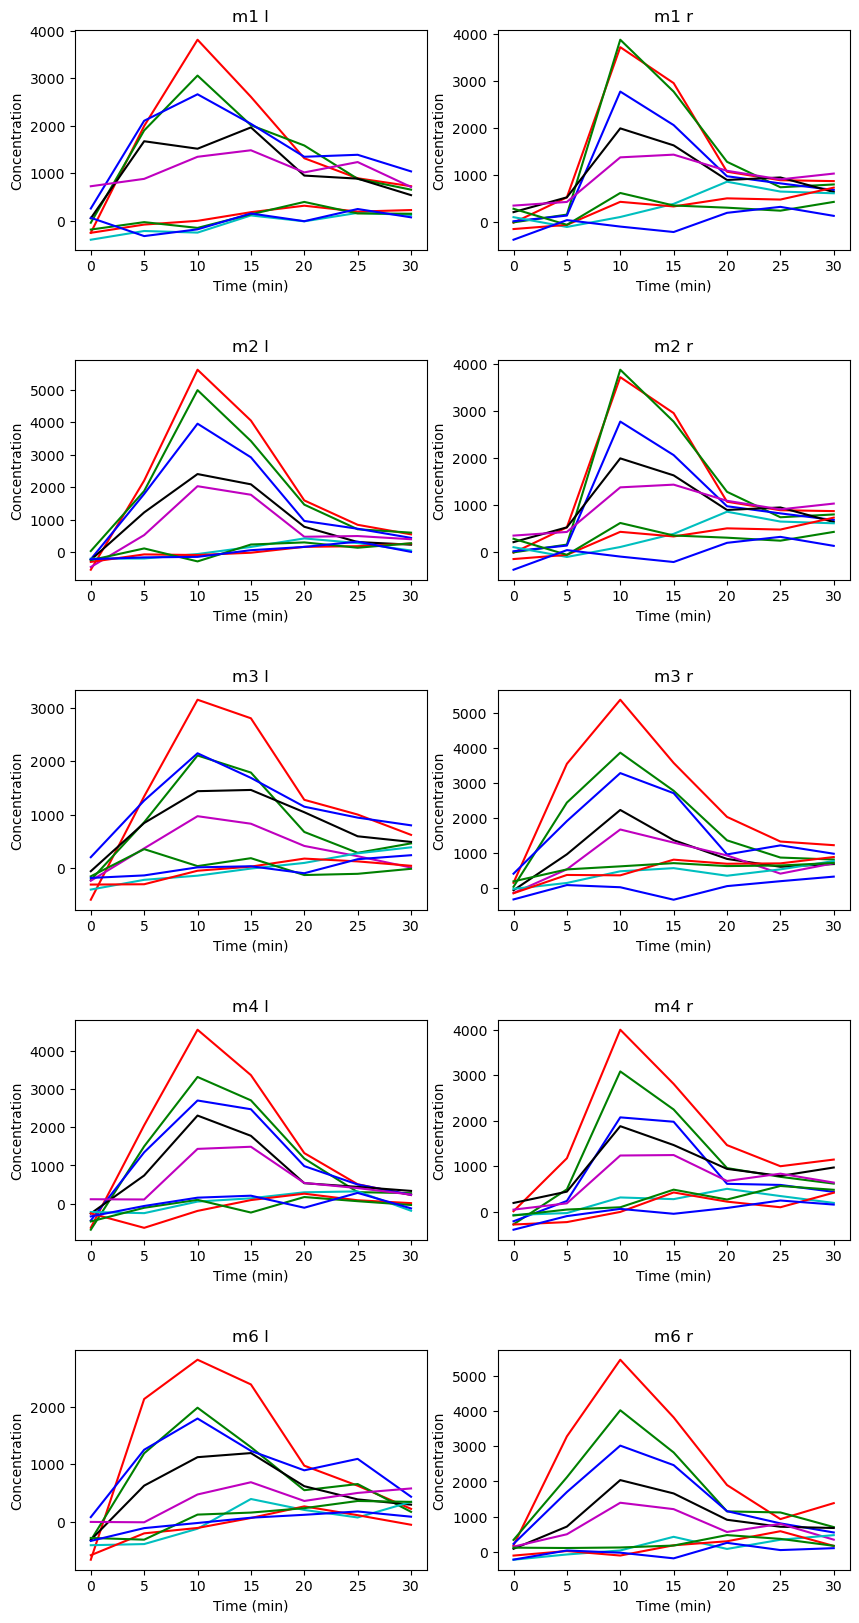

In [3]:
#idx = 2
#plot_time_series(times_list[idx], locations_list[idx], real_data_list[idx], plot_legend=True)

# create a 5 by 2 plot
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    for j in range(2):
        idx = i*2 + j
        plt.sca(axs[i, j])
        plot_time_series(times_list[idx], locations_list[idx], real_data_list[idx], plot_legend=False)
        axs[i, j].set_title(f'{args_list[idx].animal} {args_list[idx].ear}')

# Add vertical space between subplots
plt.subplots_adjust(hspace=0.5)

#### (can skip this): plot cases for num_ST = 0

CA data.
CA data.
CA data.
CA data.
CA data.
CA data.
CA data.
CA data.
CA data.
CA data.


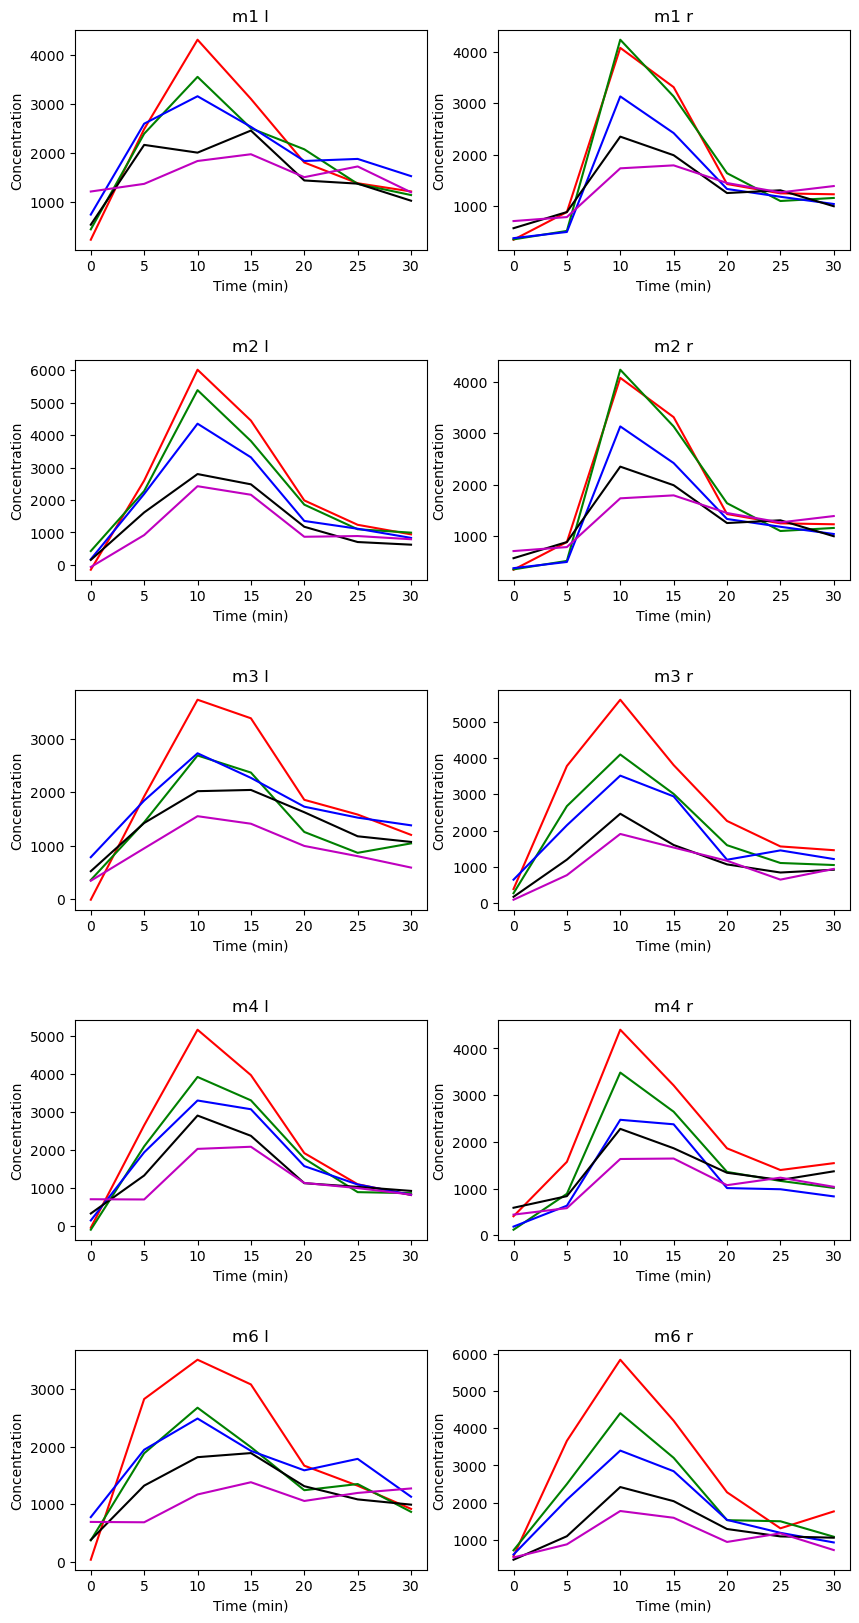

In [4]:


times_list_st0 = [] 
locations_list_st0 = []
real_data_list_st0 = []
real_std_data_list_st0 = []

max_concentration_st0 = 0
min_concentration_st0 = 0

args_list_st0 = [Args() for i in range(len(mice_list)*len(ear_list))]

# loop over all cases
for i, case in enumerate(cases_list):
    # Set animal and ear
    args_list_st0[i].animal = case[0]
    args_list_st0[i].ear = case[1]
    args_list_st0[i].num_ST = 0 

    # read
    times_st0, locations_st0, real_data_st0, real_std_data_st0, _, _, _ = read_data_files(args_list_st0[i])

    # append
    times_list_st0.append(times_st0)
    locations_list_st0.append(locations_st0)
    real_data_list_st0.append(real_data_st0.reshape(len(locations_st0), len(times_st0)))
    real_std_data_list_st0.append(real_std_data_st0.reshape(len(locations_st0), len(times_st0)))

    # update max and min concentration
    max_concentration_st0 = max(max_concentration_st0, np.max(real_data_st0))
    min_concentration_st0 = min(min_concentration_st0, np.min(real_data_st0))

# create a 5 by 2 plot
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    for j in range(2):
        idx = i*2 + j
        plt.sca(axs[i, j])
        plot_time_series(times_list_st0[idx], locations_list_st0[idx], real_data_list_st0[idx], plot_legend=False)
        axs[i, j].set_title(f'{args_list_st0[idx].animal} {args_list_st0[idx].ear}')

# Add vertical space between subplots
plt.subplots_adjust(hspace=0.5)



#### Extract data points from which the noise level is to be estimated.

The data points below the red line in the plot are used to estimate the noise level. For those data points, the true concentration is assumed to be zero.

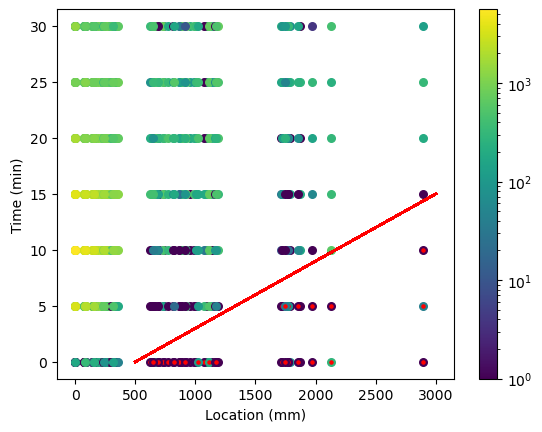

In [5]:
# plot all concentration data in 2D image (location/time) colored by concentration
data_for_noise_estimation = []
std_data_for_noise_estimation = []
data_for_noise_estimation_per_case = []
std_data_for_noise_estimation_per_case = []
for i, case in enumerate(cases_list):
    data_for_noise_estimation_per_case.append([])
    std_data_for_noise_estimation_per_case.append([])
    for j, loc in enumerate(locations_list[i]):
        for k, t in enumerate(times_list[i]/60):
            orig_data = real_data_list[i][j, k]
            orig_std_data = real_std_data_list[i][j, k]
            clipped_data = np.clip(orig_data, 1, max_concentration)
            plt.scatter(loc, t, c=clipped_data, s=30, norm=matplotlib.colors.LogNorm(vmin=1, vmax=max_concentration))
            # if data below line (500, 0) to (3000, 15), add to noise estimation
            line_eq = lambda loc_x:  15/2500*(loc_x-500)
            # draw line
            plt.plot([500, 3000], [line_eq(500), line_eq(3000)], 'r')
            if t < line_eq(loc):
                plt.scatter(loc, t, c='r', s=5)
                data_for_noise_estimation_per_case[i].append(orig_data)
                std_data_for_noise_estimation_per_case[i].append(orig_std_data)
                data_for_noise_estimation.append(orig_data)
                std_data_for_noise_estimation.append(orig_std_data)

plt.colorbar()
plt.xlabel('Location (mm)')
plt.ylabel('Time (min)')

#convert to numpy array
data_for_noise_estimation = np.array(data_for_noise_estimation)
std_data_for_noise_estimation = np.array(std_data_for_noise_estimation)




#### Compute noise estimate in concentration data
Consider the data points below the red line. Each data point j for case i ($c_i^j$), is an average of 9 voxels. It has an associated standard deviation ($\sigma_i^j$).

$$\sigma_i^j = \sqrt{\frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j - c_i^j)^2}$$

and we can write

$$ \left(\sigma_i^j\right)^2 =\frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j - c_i^j)^2$$

where $c_{i,k}^j$ is the concentration of voxel k used in estimating data point j for case i.

The noise STD for case i can be computed as

$$\sigma_i^2 = \frac{1}{n} \sum_{j=1}^n \frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j - \bar{c}_{i})^2$$

where $n$ is the number of data points below the red line for case i, and $\bar{c}_{i}$ is the average of all the $9*n$ voxel data points for case i.

Assume $\bar{c}_{i} \approx c_i^j$ for each data point j. We can write

$$\sigma_i^2 = \frac{1}{n} \sum_{j=1}^n \frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j -  c_i^j)^2$$

and thus the noise variance $\sigma_i^2$ for case i is approximated by

$$\sigma_i^2 = \frac{1}{n} \sum_{j=1}^n \left(\sigma_i^j\right)^2 $$

**Note:** we might need to consider dividing by 9-1 instead of 9 to compute the noise variance $\left(\sigma_i^j\right)^2$ and by $n*9-1$ instead of $n*9$ to compute the noise variance $\sigma_i^2$.

In [6]:
# Noise std estimation
noise_std = np.sqrt(np.average(std_data_for_noise_estimation**2))
print("Noise std: ", noise_std)
noise_std_per_case_list = []

# Noise std estimation per case
for i, case in enumerate(cases_list):
    noise_std_per_case = np.sqrt(np.average(np.array(std_data_for_noise_estimation_per_case[i])**2))
    print(f"Noise std (sigma_i) for case i={i}", case, ": ", noise_std_per_case)
    print("for verification, plot output of estimate_noise_std function", estimate_noise_std(locations=locations_list[i], times=times_list[i], real_data=real_data_list[i], real_std_data=real_std_data_list[i]))
    noise_std_per_case_list.append(noise_std_per_case)


Noise std:  292.89441389182974
Noise std (sigma_i) for case i=0 ('m1', 'l') :  284.32061209803277
for verification, plot output of estimate_noise_std function 284.32061209803277
Noise std (sigma_i) for case i=1 ('m1', 'r') :  280.34568790691253
for verification, plot output of estimate_noise_std function 280.34568790691253
Noise std (sigma_i) for case i=2 ('m2', 'l') :  312.771102205111
for verification, plot output of estimate_noise_std function 312.771102205111
Noise std (sigma_i) for case i=3 ('m2', 'r') :  291.47625867763963
for verification, plot output of estimate_noise_std function 291.47625867763963
Noise std (sigma_i) for case i=4 ('m3', 'l') :  312.493149497393
for verification, plot output of estimate_noise_std function 312.493149497393
Noise std (sigma_i) for case i=5 ('m3', 'r') :  367.29030905674597
for verification, plot output of estimate_noise_std function 367.29030905674597
Noise std (sigma_i) for case i=6 ('m4', 'l') :  242.5273744681206
for verification, plot output

#### Compute noise estimate in gradient data

The gradient data is computed as the difference between the concentration of adjacent data points j and j+1 for time t divided by the distance between the two data points. The noise variance of the difference is the sum of the variances of the two data points, and taking the distance into account, we can write

$$\sigma_{\nabla c}^2 = \frac{\sigma_{c}^2 + \sigma_{c}^2}{\Delta x^2}$$

where $\sigma_{c}^2$ is the noise variance in concentration data.

In [7]:
# Noise estimation in data gradient
grad_data_std = np.sqrt(2)*noise_std
print("Grad data std: ", grad_data_std)
print("this value need to be devided by location difference")
print()

# Noise estimation in data gradient per case
for i, case in enumerate(cases_list):
    grad_data_std_per_case = np.sqrt(2)*noise_std_per_case_list[i]
    print("Grad data std for case ", case, ": ", grad_data_std_per_case)
    print("Note: this value need to be divided by location difference")
    std_scaled, cov = estimate_grad_data_noise_std(data_noise_std=noise_std_per_case_list[i], locations=locations_list[i], real_data_diff=real_data_diff_list[i].reshape(len(diff_locations_list[i]), -1))
    print("for verification, plot first output of estimate_grad_data_noise_std function")
    print(std_scaled)
    print(np.diag(cov))
    print()

Grad data std:  414.21525246914433
this value need to be devided by location difference

Grad data std for case  ('m1', 'l') :  402.09006569125785
Note: this value need to be divided by location difference
for verification, plot first output of estimate_grad_data_noise_std function
402.09006569125785
[31.09161941 31.09161941 31.09161941 31.09161941 31.09161941 31.09161941
 31.09161941 31.09161941 31.09161941 31.09161941 31.09161941 31.09161941
 31.09161941 31.09161941 22.45505846 22.45505846 22.45505846 22.45505846
 22.45505846 22.45505846 22.45505846 28.87078945 28.87078945 28.87078945
 28.87078945 28.87078945 28.87078945 28.87078945  1.43840232  1.43840232
  1.43840232  1.43840232  1.43840232  1.43840232  1.43840232  2.92892067
  2.92892067  2.92892067  2.92892067  2.92892067  2.92892067  2.92892067
  3.45462438  3.45462438  3.45462438  3.45462438  3.45462438  3.45462438
  3.45462438  0.33542826  0.33542826  0.33542826  0.33542826  0.33542826
  0.33542826  0.33542826]

Grad data std 

#### Just for illustration, plot the data points used to estimate the noise level

avg:  -163.25957604395606
max:  281.3121714285714
min:  -580.375


Text(0, 0.5, 'Data value')

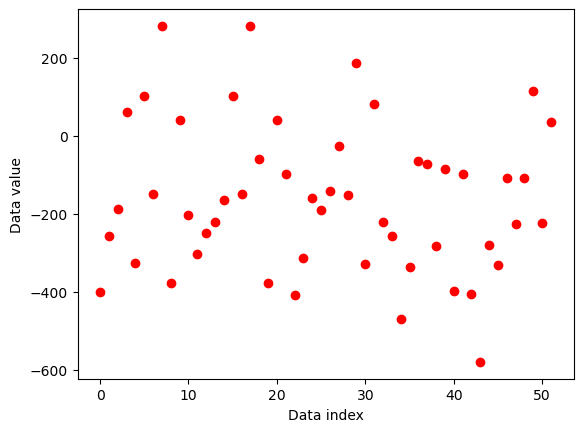

In [8]:
print("avg: ", np.average(data_for_noise_estimation))
print("max: ", np.max(data_for_noise_estimation))
print("min: ", np.min(data_for_noise_estimation))
plt.plot(data_for_noise_estimation, 'ro')
plt.xlabel('Data index')
plt.ylabel('Data value')